In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#### Load data
___

In [2]:
df = pd.read_excel('../data/Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.shape

(541909, 8)

#### Check if there is missing data
___

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### Drop rows with nulls and check again
___

In [7]:
df = df.dropna()
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### See if we have duplicates
___

In [8]:
df.duplicated().sum()

5225

#### Drop duplicates and check again
___

In [9]:
df = df.drop_duplicates()
df.duplicated().sum()

0

#### Cast columns to appropriate types
___

In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

In [12]:
df['CustomerID'] = df['CustomerID'].astype(int)

In [13]:
sns.set_style('darkgrid')
sns.set(font_scale=1)

#### Explore the data
___

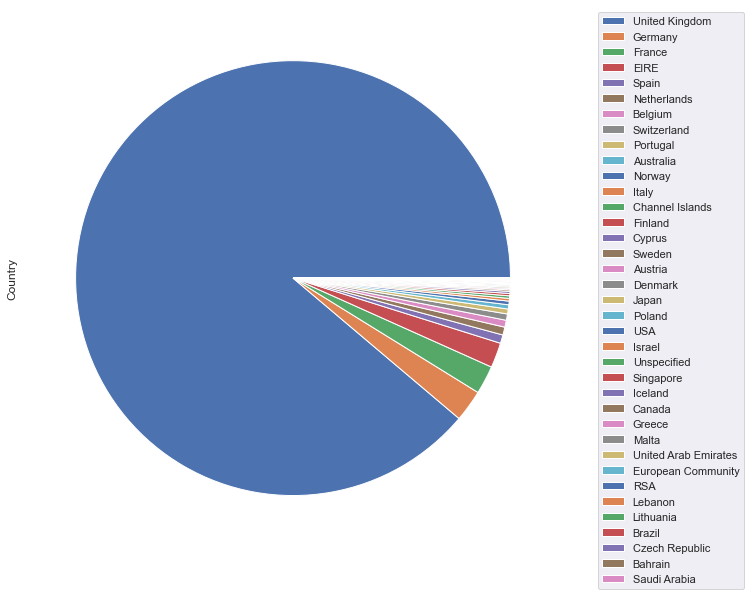

In [14]:
_, ax = plt.subplots(figsize=(12, 10))
_ = df['Country'].value_counts().plot.pie(ax=ax,
                                          labels=list(str(' ') * 
                                                      len(df['Country'].unique())))
_ = ax.legend(loc='best', bbox_to_anchor=(1.05, 1), 
              labels=df['Country'].value_counts().index)

#### See how many unique column entries exist in ∼ 400,000 rows
___

In [15]:
for column in df.columns:
    print(column, '\t::', len(df[column].value_counts()))

InvoiceNo 	:: 22190
StockCode 	:: 3684
Description 	:: 3896
Quantity 	:: 436
InvoiceDate 	:: 20460
UnitPrice 	:: 620
CustomerID 	:: 4372
Country 	:: 37


##### *-> 3684 unique products present.*
##### *-> 4372 customer details covered.*
##### *-> 37 countries represented.*

In [16]:
orders = df.groupby(['CustomerID', 'InvoiceNo']).size()

In [17]:
orders

CustomerID  InvoiceNo
12346       541431        1
            C541433       1
12347       537626       31
            542237       29
            549222       24
                         ..
18283       579673       50
            580872       50
18287       554065       29
            570715       38
            573167        3
Length: 22190, dtype: int64

##### *-> An invoice number starting with 'C' means cancellation.*

#### Check how many orders are cancelelled ones in the dataset
___

In [18]:
cancelled_orders = (
    orders[orders.index.get_level_values('InvoiceNo').str.startswith('C')])
len(cancelled_orders)

3654

In [19]:
(len(cancelled_orders) / len(orders)) * 100

16.466876971608833

##### *-> Some 16% of orders are cancelled ones.*
##### *-> Let's get rid of these too. Should we ust delete all cancelled orders?*
##### *-> For the first customer in the above `orders` series we see something interesting.*
##### *-> Looks like a cancelled order has a counterpart (541431 is the order and C541433 is its cancellation)*

In [20]:
df[df.CustomerID == 12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


##### *-> Everything is the same except for __InvoiceNo__, __InvoiceDate__ and __Quantity__ (which is negative of original order quantity)*

In [21]:
cancelled_orders_df = df[df.InvoiceNo.isin(
    cancelled_orders.index.get_level_values('InvoiceNo'))]

In [22]:
cancelled_orders_counterparts = []
for _, row in cancelled_orders_df.iterrows():
    cancelled_orders_counterparts.append((row.StockCode, row.Description, 
                                          -row.Quantity, row.UnitPrice, 
                                          row.CustomerID, row.Country, row.InvoiceDate))

In [23]:
for (stock_code, description, quantity, unit_price, 
     customer_id, country, invoice_date) in cancelled_orders_counterparts:
    entry = df[(df.StockCode == stock_code) & (df.Description == description) & 
               (df.Quantity == quantity) & (df.UnitPrice == unit_price) & 
               (df.CustomerID == customer_id) & (df.Country == country)]
    if len(entry) > 1:
        print(entry)
        break

       InvoiceNo StockCode                Description  Quantity  \
119473    546543     22355  CHARLOTTE BAG SUKI DESIGN         2   
140961    548492     22355  CHARLOTTE BAG SUKI DESIGN         2   
146715    549014     22355  CHARLOTTE BAG SUKI DESIGN         2   
159733    550359     22355  CHARLOTTE BAG SUKI DESIGN         2   
206562    554942     22355  CHARLOTTE BAG SUKI DESIGN         2   
214010    555562     22355  CHARLOTTE BAG SUKI DESIGN         2   
303345    563538     22355  CHARLOTTE BAG SUKI DESIGN         2   
306551    563771     22355  CHARLOTTE BAG SUKI DESIGN         2   
309824    564141     22355  CHARLOTTE BAG SUKI DESIGN         2   
393284    570818     22355  CHARLOTTE BAG SUKI DESIGN         2   

               InvoiceDate  UnitPrice  CustomerID         Country  
119473 2011-03-14 15:40:00       0.85       17841  United Kingdom  
140961 2011-03-31 13:14:00       0.85       17841  United Kingdom  
146715 2011-04-05 15:00:00       0.85       17841  United 

##### *-> More than one entry exists for the same combination. It makes sense since a customer can place similar kind of order over and over again.*

#### Check when the order was cancelled
___

In [24]:
cancelled_orders_df[(cancelled_orders_df.CustomerID == 17841) & 
                    (cancelled_orders_df.StockCode == 22355)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1442,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,2010-12-01 14:30:00,0.85,17841,United Kingdom


##### *-> It seems this cancellation is for an older order that's not a part of this dataset.*
##### *-> Anyways, given that we can have multiple entries, let's delete the first entry after cancellation __InvoiceDate__ since that's the correct counterpart of cancelled transaction.*

In [25]:
counterpart_indices_to_drop = []
for (stock_code, description, quantity, unit_price, 
     customer_id, country, invoice_date) in cancelled_orders_counterparts:
    entry = df[(df.StockCode == stock_code) & (df.Description == description) & 
               (df.Quantity == quantity) & (df.UnitPrice == unit_price) & 
               (df.CustomerID == customer_id) & (df.Country == country) & 
               (df.InvoiceDate < invoice_date)]
    if len(entry) > 0:
        counterpart_indices_to_drop.append(entry.iloc[0].name)

In [26]:
len(counterpart_indices_to_drop)

2771

#### Drop the cancelled orders along with their above found counterparts
___

In [27]:
df.drop(counterpart_indices_to_drop, axis=0, inplace=True)

In [28]:
df = df.merge(cancelled_orders_df, how='left', indicator=True)
df = df[df['_merge'] == 'left_only']
df = df.drop(columns='_merge')

#### See if we got rid of all cancelled orders
___

In [29]:
df.InvoiceNo.str.startswith('C').unique()

array([False])

##### *-> The dataset is cleaner now. Noice!*

#### Analyze how much have the customers spent
___

In [30]:
grouping = df.groupby(['CustomerID'])

In [31]:
spend_data = grouping.apply(lambda x: (x.UnitPrice * x.Quantity).sum())

In [32]:
bins = list(range(int(spend_data.min()), int(spend_data.max())+10000, 10000))
spend_buckets = pd.cut(spend_data, bins).value_counts()
spend_buckets

(0, 10000]          4227
(10000, 20000]        60
(20000, 30000]        12
(30000, 40000]         8
(50000, 60000]         7
(60000, 70000]         4
(40000, 50000]         2
(120000, 130000]       1
(80000, 90000]         1
(110000, 120000]       1
(270000, 280000]       1
(130000, 140000]       1
(250000, 260000]       1
(180000, 190000]       1
(70000, 80000]         0
(240000, 250000]       0
(230000, 240000]       0
(220000, 230000]       0
(210000, 220000]       0
(200000, 210000]       0
(160000, 170000]       0
(150000, 160000]       0
(90000, 100000]        0
(100000, 110000]       0
(170000, 180000]       0
(260000, 270000]       0
(140000, 150000]       0
(190000, 200000]       0
dtype: int64

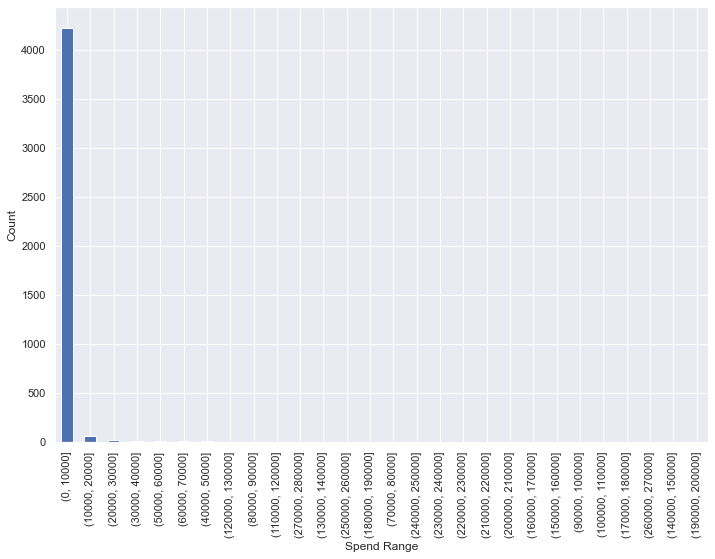

In [33]:
_ = spend_buckets.plot.bar(figsize=(11.7, 8), rot=90,
                           xlabel ="Spend Range", ylabel='Count')

##### *-> About 98% of customers in the dataset have spent under 10,000 in total.*

#### Check the spread amongst these 98% customers
___

In [34]:
spend_under_10k = spend_data[spend_data <= 10000]

In [35]:
bins = list(range(int(spend_under_10k.min()), int(spend_under_10k.max())+500, 500))
spend_under_10k_buckets = pd.cut(spend_under_10k, bins).value_counts()
spend_under_10k_buckets

(0, 500]         1773
(500, 1000]       905
(1000, 1500]      475
(1500, 2000]      291
(2000, 2500]      193
(2500, 3000]      145
(3000, 3500]      100
(3500, 4000]       82
(4000, 4500]       54
(4500, 5000]       41
(5000, 5500]       34
(5500, 6000]       31
(6500, 7000]       23
(6000, 6500]       21
(7000, 7500]       15
(7500, 8000]       12
(8000, 8500]       10
(8500, 9000]        9
(9500, 10000]       8
(9000, 9500]        5
dtype: int64

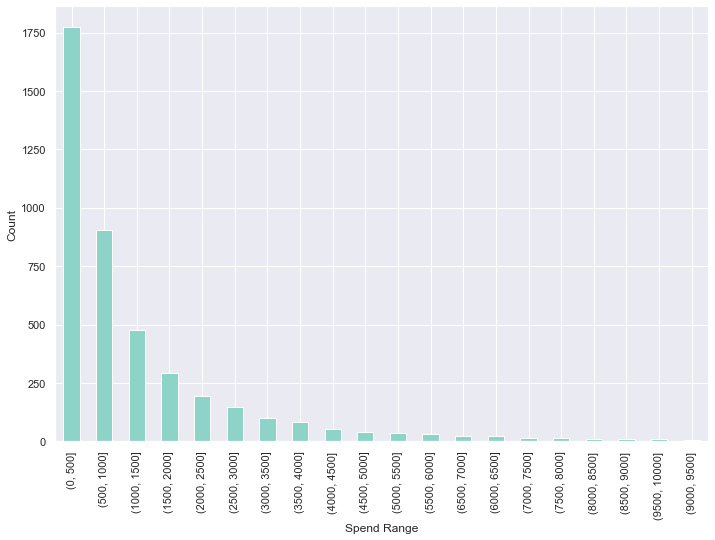

In [36]:
_ = spend_under_10k_buckets.plot.bar(figsize=(11.7, 8), rot=90,
                                     colormap="Set3",
                                     xlabel ="Spend Range", ylabel='Count')

##### *-> More number of customers spend less and vice-versa.*

#### Analyze the difference between first and last invoice dates of customers to get an idea about returning customers
___

In [37]:
returning_customers = df.loc[:, ['CustomerID', 'InvoiceDate']]

In [38]:
returning_customers['Month'] = returning_customers['InvoiceDate'].apply(
    lambda x: dt.datetime(x.year, x.month, 1))

In [39]:
grouping = returning_customers.groupby('CustomerID')['Month']

In [40]:
returning_customers['FirstMonth'] = grouping.transform('min')
returning_customers['LastMonth'] = grouping.transform('max')

In [41]:
returning_customers = returning_customers.drop_duplicates(
    subset=['CustomerID', 'FirstMonth', 'LastMonth'])

In [42]:
returning_customers = returning_customers.groupby(['FirstMonth', 
                                                   'LastMonth']).size().to_frame()

In [43]:
returning_customers.columns = ['Count']

In [44]:
returning_customers = returning_customers.reset_index()

In [45]:
returning_customers['FirstMonth'] = returning_customers['FirstMonth'].astype(str)
returning_customers['LastMonth'] = returning_customers['LastMonth'].astype(str)

In [46]:
returning_customers['FirstMonth'] = (returning_customers['FirstMonth']
                                     .str.slice(0, -3))
returning_customers['LastMonth'] = (returning_customers['LastMonth']
                                    .str.slice(0, -3))

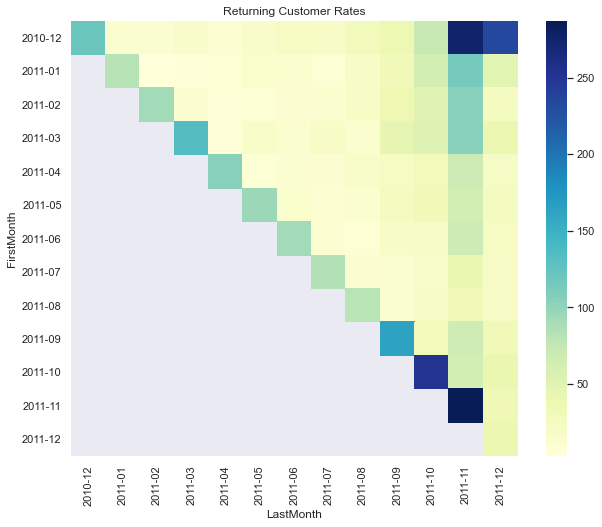

In [47]:
_ = plt.figure(figsize=(10, 8))
_ = plt.title('Returning Customer Rates')
_ = sns.heatmap(returning_customers.pivot(index='FirstMonth',
                                          columns='LastMonth',
                                          values='Count'), cmap="YlGnBu")

##### *-> Looks like there are many returning customers. We can see that above 200 had their first and last order placed in the first and last months of the dataset.*

#### Compute some meaningful values for each customer: 
##### &ensp; 1. OrderCount = How many times the customer placed an order?
##### &ensp; 2. Spend = How much money did the customer spend? Same as the *Spend Range* we explored above.
___

In [48]:
df['Spend'] = df['Quantity'] * df['UnitPrice']

In [49]:
customer_info = df.groupby('CustomerID').agg({
    'Spend': 'sum',
    'InvoiceNo': 'count'
})

In [50]:
customer_info.rename(columns={'InvoiceNo': 'OrderCount'}, inplace=True)

In [51]:
customer_info

,Spend,OrderCount
CustomerID,,
12347,4310.00,182
12348,1797.24,31
12349,1757.55,73
12350,334.40,17
12352,2385.71,78
...,...,...
18280,180.60,10
18281,80.82,7
18282,178.05,12


#### Use k-Means, the unsupervised learning algorithm, to create clusters of customers
___

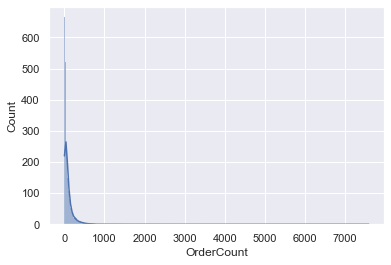

In [52]:
_ = sns.histplot(customer_info['OrderCount'], kde=True)

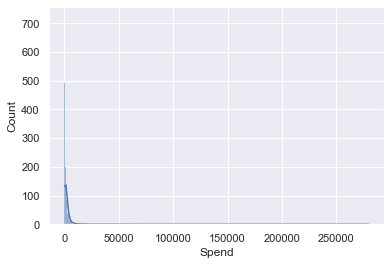

In [53]:
_ = sns.histplot(customer_info['Spend'], kde=True)

##### *-> The data is really skewed so let's do log transformation*

In [54]:
customer_info = customer_info.loc[(customer_info > 0).all(axis=1)]

In [55]:
customer_log = np.log(customer_info)

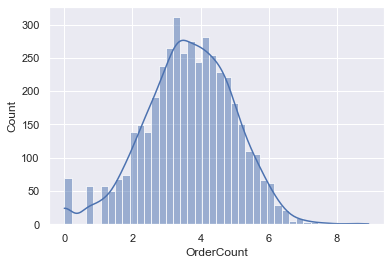

In [56]:
_ = sns.histplot(customer_log['OrderCount'], kde=True)

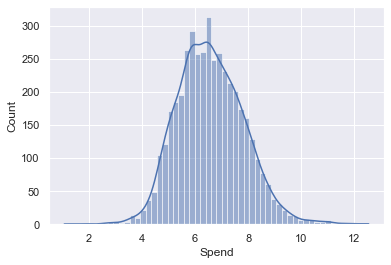

In [57]:
_ = sns.histplot(customer_log['Spend'], kde=True)

##### *-> The skewness has been taken care of now as can be seen in the above two plots*

In [58]:
customer_log.describe()

,Spend,OrderCount
count,4327.000000,4327.000000
mean,6.572267,3.666815
std,1.258625,1.321747
min,1.064711,0.000000
25%,5.717373,2.833213
50%,6.491345,3.713572
75%,7.403759,4.584967
max,12.541995,8.934587


In [59]:
scaler = StandardScaler()
scaler.fit(customer_log)
normalized_data = scaler.transform(customer_log)

##### *-> Normalized the data because k-Means expects variables with same average values and variance*

In [60]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(normalized_data)
    sse[k] = kmeans.inertia_ 

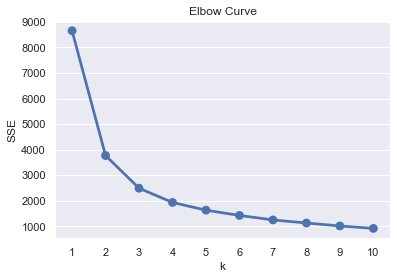

In [61]:
_ = plt.title('Elbow Curve')
_ = plt.xlabel('k')
_ = plt.ylabel('SSE')
_ = sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

##### *-> We used the Elbow Method above to pick the most suitable k values. Let's pick k=3*

In [62]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(normalized_data)
cluster_labels = kmeans.labels_
customer_info_k3 = customer_info.assign(Cluster=cluster_labels)

In [63]:
customer_info_k3.groupby('Cluster').agg({
    'OrderCount': 'mean',
    'Spend': 'mean'
}).round(0)

,OrderCount,Spend
Cluster,,
0,11.0,242.0
1,234.0,5564.0
2,48.0,742.0


##### *-> Cluster **0** has customers with least average orders and spend whereas cluster **1** has customers with highest average orders and spend.*

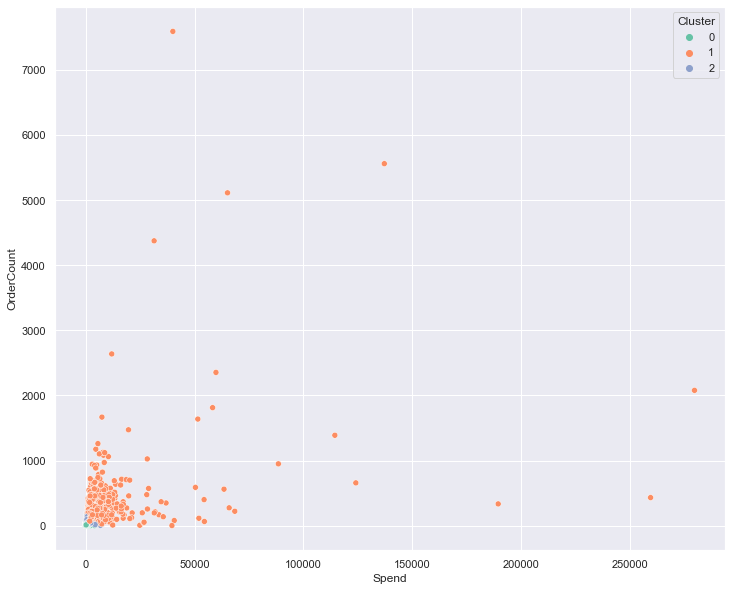

In [66]:
_ = plt.subplots(figsize=(12, 10))

_ = sns.scatterplot(x='Spend', y='OrderCount',
                    hue='Cluster', palette='Set2', 
                    data=customer_info_k3)

##### *-> Looks like we have some really platinum category customers so the scatter looks like above*
##### *-> Indeed, when we were exploring the data we saw the same situation where some 2% customers had comparatively very high spend value*

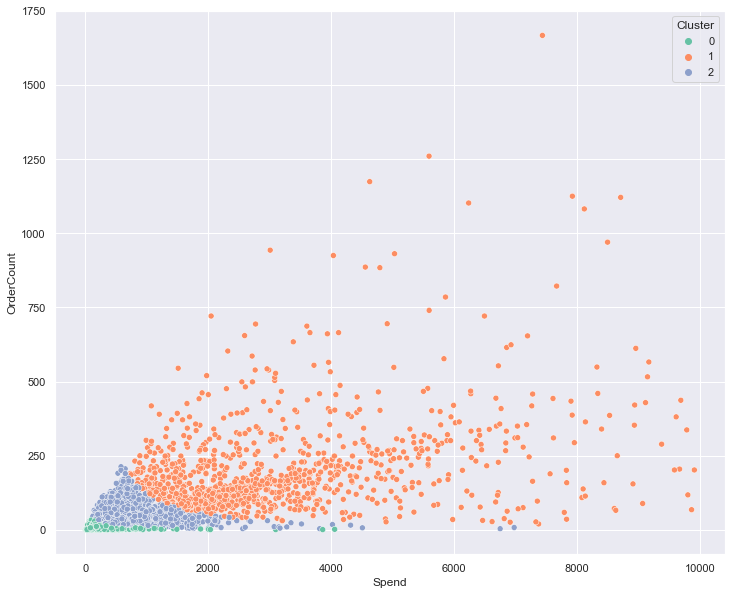

In [67]:
_ = plt.subplots(figsize=(12, 10))

_ = sns.scatterplot(x='Spend', y='OrderCount',
                    hue='Cluster', palette='Set2',
                    data=customer_info_k3[customer_info_k3.Spend <= 10000])

##### *-> The above scatter plot with customers having spend below 10k gives a better picture about how clusters have been created.*